# Calculate song information contained in individual MA neurons

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

import warnings
warnings.filterwarnings("ignore")

from disp import set_plot
from record_0_main import smlt_ma


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

# Plot song information contained in individual neural responses

Load response entropies and model neuron params

In [2]:
data = np.load(
    'data/simple/compression/single_nrn_rsp_entropies.npy',
    allow_pickle=True)[0]

tau_rs = data['TAU_R']
tau_as = data['TAU_A']
x_ss = data['X_S']
x_ps = data['X_P']
hs = data['HS']
hs_scrm = data['HS_SCRM']

TAU_R = np.sort(np.unique(tau_rs))
TAU_A = np.sort(np.unique(tau_as))
X_S = np.sort(np.unique(x_ss))
X_P = np.sort(np.unique(x_ps))

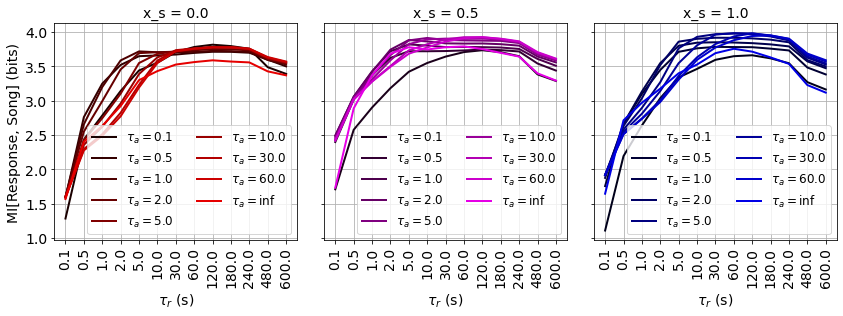

In [3]:
# plot entropies vs tau_r, tau_a, and selectivity
fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), tight_layout=True, sharex=True, sharey=True)
colors = [np.array([1, 0, 0]), np.array([1, 0, 1]), np.array([0, 0, 1])]

for ax, c, x_s in zip(axs, colors, X_S):
    mx_s = np.isclose(x_ss, x_s)
    # loop over adaptation rates
    for ctau_a, tau_a in enumerate(TAU_A):
        if ~np.isinf(tau_a):
            mtau_a = np.isclose(tau_as, tau_a)
        else:
            mtau_a = np.isinf(tau_as)
        
        # get tau_rs and entropies of neurons with this x_s and tau_a
        tau_rs_ = tau_rs[mx_s & mtau_a]
        hs_ = hs[mx_s & mtau_a]
        
        color = c*(.1 + (1-.1)*ctau_a/len(TAU_A))
        ax.plot(np.arange(len(TAU_R)), hs_, lw=2, c=color)
    
    ax.set_xticks(np.arange(len(TAU_R)))
    ax.set_xticklabels([f'{tau_r:.1f}' for tau_r in TAU_R], rotation=90)
    ax.set_xlabel(r'$\tau_r$ (s)')
    ax.set_title(f'x_s = {x_s}')
    
axs[0].set_ylabel('MI[Response, Song] (bits)')
for ax in axs:
    set_plot(ax, font_size=14)
    ax.legend([r'$\tau_a = $' + f'{tau_a:.1f}' for tau_a in TAU_A], ncol=2, fontsize=12)
    ax.grid()

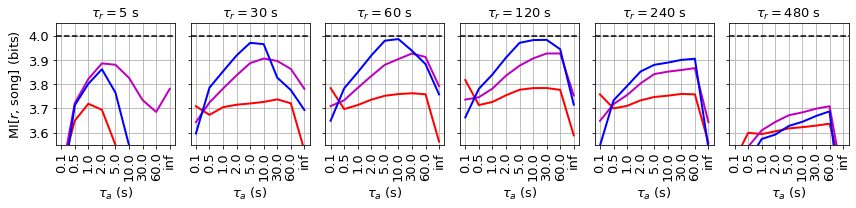

In [4]:
NBIN = 16

# plot entropy vs TAU_A for several different TAU_R
tau_rs_show = [5, 30, 60, 120, 240, 480]
colors = ['r', 'm', 'b']

fig, axs = plt.subplots(
    1, len(tau_rs_show), figsize=(2*len(tau_rs_show), 3),
    tight_layout=True, sharex=True, sharey=True)

for cax, (ax, tau_r) in enumerate(zip(axs, tau_rs_show)):
    mtau_r = np.isclose(tau_rs, tau_r)
    for x_s, c in zip(X_S, colors):
        mx_s = np.isclose(x_ss, x_s)
        # get tau_as and entropies of responses w/ this tau_r and x_s
        tau_as_ = tau_as[mtau_r & mx_s]
        hs_ = hs[mtau_r & mx_s]
        
        assert list(tau_as_) == sorted(tau_as_)
        
        ax.plot(np.arange(len(TAU_A)), hs_, lw=2, c=c)
        
    ax.axhline(np.log2(NBIN), c='k', ls='--')
        
    ax.set_xticks(np.arange(len(TAU_A)))
    ax.set_xticklabels([f'{tau_a}' for tau_a in TAU_A], rotation=90)
    ax.set_xlabel(r'$\tau_a$ (s)')
    if ax is axs[0]:
        ax.set_ylabel(r'MI[$r$, song] (bits)')
    ax.set_title(r'$\tau_r =$' + f'{tau_r} s')
    ax.grid()
    
# ax.legend(['Pulse selective', 'Mixed selective', 'Sine selective'])

for ax in axs:
    ax.set_ylim(bottom=3.55, top=4.05)
    set_plot(ax, font_size=13)
    
fig.savefig('ms/fig_3e.svg')

# Plot fMTN var explained by individual model neurons

In [5]:
TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

FLOAD = f'data/simple/mlv/ma_built/ma_built_nrl_single_{STRAIN_KEY}_r2.npy'
data = np.load(FLOAD, allow_pickle=True)[0]

In [6]:
r2_tests = data['r2_test']

In [7]:
TARG = TARGS[1]  # 1-second avging

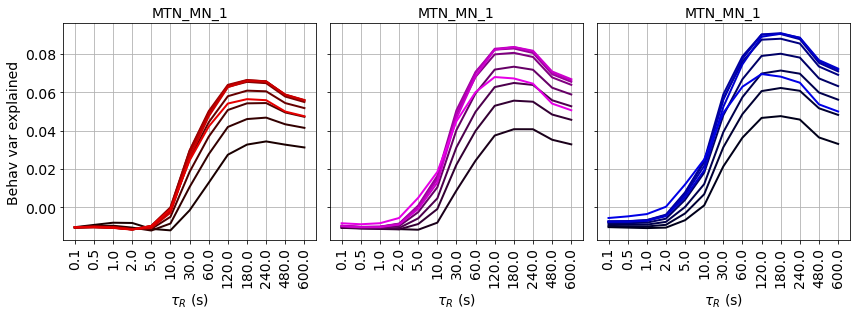

In [8]:
r2s = r2_tests[TARG]
# plot R2 vs tau_r, tau_a, and selectivity
fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), tight_layout=True, sharex=True, sharey=True)
colors = [np.array([1, 0, 0]), np.array([1, 0, 1]), np.array([0, 0, 1])]

for ax, c, x_s in zip(axs, colors, X_S):
    mx_s = np.isclose(x_ss, x_s)
    # loop over adaptation rates
    for ctau_a, tau_a in enumerate(TAU_A):
        if ~np.isinf(tau_a):
            mtau_a = np.isclose(tau_as, tau_a)
        else:
            mtau_a = np.isinf(tau_as)

        # get tau_rs and  of neurons with this x_s and tau_a
        tau_rs_ = tau_rs[mx_s & mtau_a]
        r2s_ = r2s[mx_s & mtau_a]

        color = c*(.1 + (1-.1)*ctau_a/len(TAU_A))
        ax.plot(np.arange(len(TAU_R)), r2s_, lw=2, c=color)

    ax.set_xticks(np.arange(len(TAU_R)))
    ax.set_xticklabels([f'{tau_r:.1f}' for tau_r in TAU_R], rotation=90)
    ax.set_xlabel(r'$\tau_R$ (s)')
    ax.set_title(f'x_s = {x_s}')

axs[0].set_ylabel('Behav var explained')
for ax in axs:
    set_plot(ax, title=f'{TARG}', font_size=14)
#         ax.legend([r'$\tau_a = $' + f'{tau_a:.3f}' for tau_a in TAU_A], ncol=2, fontsize=12)
    ax.grid()

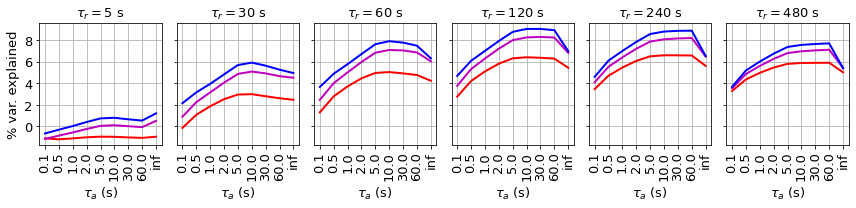

In [9]:
# plot R2 vs TAU_A for several different TAU_R
colors = ['r', 'm', 'b']

fig, axs = plt.subplots(
    1, len(tau_rs_show), figsize=(2*len(tau_rs_show), 3),
    tight_layout=True, sharex=True, sharey=True)

for cax, (ax, tau_r) in enumerate(zip(axs, tau_rs_show)):
    mtau_r = np.isclose(tau_rs, tau_r)
    for x_s, c in zip(X_S, colors):
        mx_s = np.isclose(x_ss, x_s)
        # get tau_as and R2s of responses w/ this tau_r and x_s
        tau_as_ = tau_as[mtau_r & mx_s]
        r2s_ = r2s[mtau_r & mx_s]

        assert list(tau_as_) == sorted(tau_as_)

        ax.plot(np.arange(len(TAU_A)), 100*r2s_, lw=2, c=c)

    ax.set_xticks(np.arange(len(TAU_A)))
    ax.set_xticklabels([f'{tau_a}' for tau_a in TAU_A], rotation=90)
    ax.set_xlabel(r'$\tau_a$ (s)')
    if ax is axs[0]:
        ax.set_ylabel('% var. explained')
    ax.set_title(r'$\tau_r =$' + f'{tau_r} s')
    ax.grid()

# ax.legend(['Pulse selective', 'Mixed selective', 'Sine selective'])

for ax in axs:
    set_plot(ax, font_size=13)
    
fig.savefig('ms/fig_3f.svg')

# Make scatter plot directly comparing song info vs behav var explained

In [10]:
from scipy import optimize

# fit exponential
def exp(x, x_scale, x_shift, y_scale, y_shift):
    return np.exp((x-x_shift)/x_scale)*y_scale + y_shift

p0 = np.array([1, 3.5, 2, -1])

p_opt = optimize.curve_fit(exp, hs, 100*r2s)[0]

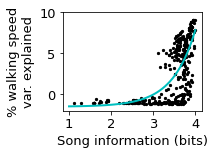

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.25), tight_layout=True)

ax.scatter(hs, 100*r2s, c='k', s=5)
ax.plot(np.linspace(1, 4, 51), exp(np.linspace(1, 4, 51), *p_opt), c='c', lw=2)
set_plot(ax, y_lim=(-2, 10), x_label='Song information (bits)', y_label='% walking speed\nvar. explained', font_size=13)

fig.savefig('ms/fig_3g.svg')